# Natural Language Processing Course Project
### Politecnico di Milano, A.Y. 2024/2025

This notebook has been created for the Natural Language Processing course, held by Prof. Carman.

**Authors**:
* Matteo Figini
* Riccardo Figini
* Samuele Forner
* Caterina Motti
* Simone Zacchetti

The purpose of this notebook is to apply different NLP techniques to analyse the **RecipeNLG** dataset, you can find the dataset at the following [link](https://huggingface.co/datasets/mbien/recipe_nlg).

In [1]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import ast
from collections import defaultdict
import matplotlib.pyplot as plt

## Preliminary analysis

In this section, we aim to perform a preliminary analysis of the dataset.
- Load and inspect the dataset: analyze which field are present, missing field or inconsistencies. 
- Analyze recipe distribution: compute statistics and visualize them.
- Analyze entities distribution: compute statistics and visualize them.

### Load and inspect the dataset

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/recipenlg/dataset/full_dataset.csv")
print(df.head())

   Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com

In [3]:
# Show the name of the columns
print("Columns:", df.columns.tolist())

Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']


In [4]:
# Dataset length
print(f"In the dataset there are {len(df)} different recipes!")

In the dataset there are 2231142 different recipes!


As we can see, the dataset contains 2231142 entries in 7 columns:
- id (int): ID.
- title (str): title of the recipe.
- ingredients (list of str): ingredients.
- directions (list of str): instruction steps.
- link (str): URL link.
- source (ClassLabel): origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    - "Gathered" (0): additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    - "Recipes1M" (1): recipes from the "Recipe1M+" dataset.
- NER (list of str): NER food entities.

Now, we check for **inconsistencies** and remove them if needed.

In [5]:
# Rows with missing values
rows_with_null = df.isnull().any(axis=1).sum()
print(f"There are {rows_with_null} rows with at least one null value.")
print(df.isnull().sum())

There are 1 rows with at least one null value.
Unnamed: 0     0
title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


The missing value is a title, which is not a critical field. However, we prefer to remove it.

In [6]:
# Delete rows with at least one missing value
df.dropna()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [7]:
# Find duplicates by title
duplicate_counts = df['title'].value_counts()

print("Duplication results by: ", duplicate_counts)

Duplication results by:  title
Chicken Casserole                      4099
Broccoli Casserole                     3985
Squash Casserole                       2508
Cheese Ball                            2426
Zucchini Bread                         2298
                                       ... 
House Slytherin Key Lime Bars             1
Cheesy Loaded Hash Browns Casserole       1
Low Carb Mexican Chicken                  1
Old Fashioned Cocoa                       1
Polpette in Spicy Tomato Sauce            1
Name: count, Length: 1312870, dtype: int64


Here we have lots of duplicates. However, they might represent different variations of the same recipe which could be useful for further analysis. 

In [8]:
# Randomly sample 1% of the dataset
df = df.sample(frac=0.01, random_state=42)

### Analyze vocaboulary

In [9]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# Apply the join operation to each row of the 'directions' column to create a single string
df['directions'] = df['directions'].apply(ast.literal_eval)
directions_col = df['directions']
all_instructions_list = [instruction for instructions in directions_col for instruction in instructions]

# Preprocess the text
full_text = ' '.join(all_instructions_list)

# Convert to lowercase and remove non-alphanumeric characters
full_text = full_text.lower()
full_text = re.sub(r'[^a-zA-Z0-9\s]', '', full_text)

# Tokenize the text into words
words = full_text.split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
words_nostopwords = [w for w in words if w not in stop_words]

# Frequency distribution of words
fdist = FreqDist(words_nostopwords)

In [28]:
# Vocabulary size
vocabulary_size = len(fdist)

# Average number of unique words per recipe
avg_unique_words = len(set(words_nostopwords)) / len(all_instructions_list)

# Word length distribution
word_lengths = [len(word) for word in words_nostopwords]
avg_word_length = sum(word_lengths) / len(word_lengths)
min_word_length = min(word_lengths)
max_word_length = max(word_lengths)

print(f"Vocabulary Size: {vocabulary_size}")
print(f"Average number of unique words per recipe: {avg_unique_words:.2f}")
print(f"Average word length: {avg_word_length:.2f} characters")
print(f"Minimum word length: {min_word_length} characters")
print(f"Maximum word length: {max_word_length} characters")

Vocabulary Size: 17964
Average number of unique words per recipe: 0.12
Average word length: 5.28 characters
Minimum word length: 1 characters
Maximum word length: 194 characters


In [29]:
# Display the top 10 most common words
print("\nTop 10 most common words:")
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")


Top 10 most common words:
add: 27522
minutes: 24246
heat: 16098
mix: 12498
pan: 11430
bowl: 11386
cook: 11022
stir: 10973
1: 10942
mixture: 10886


### Analyze recipes distribution
Since the recipes are the core of the dataset, it may be useful to analyse the length of each recipe to plot their distribution.

Recipes with very high or very low word counts might be outliers. Analyzing the distribution allows us to detect these outliers, which might skew our analysis. For instance, a recipe with only one word might be a mistake.

In [30]:
print(df[['directions']])

                                                directions
2015528  [Remove tenderloin from steak., Score meat., C...
1608734  [combine all ingredients in slow cooker (6 qua...
778500   [Cook 3 to 4 carrots; cut crosswise in 1-inch ...
1334975  [Mix all dry ingredients in a bowl., , Add cri...
116562   [Mix and press in baking pan, approximately 13...
...                                                    ...
1664318  [On a foil lined baking sheet, place the mint ...
195905   [Preheat oven to 350°., In a 5-quart Dutch ove...
2014553  [Wash Basil in sink and drain with Collander/ ...
71391    [Prepare dressing according to package directi...
975226   [In food processor: dump the first five ingred...

[22307 rows x 1 columns]


In [31]:
# Define a new column to count the number of words in 'directions'
df['dir_word_count'] = df['directions'].apply(lambda x: len(' '.join(x).split()))

# Print the new column with word counts
print(df[['directions', 'dir_word_count']])

                                                directions  dir_word_count
2015528  [Remove tenderloin from steak., Score meat., C...              31
1608734  [combine all ingredients in slow cooker (6 qua...             122
778500   [Cook 3 to 4 carrots; cut crosswise in 1-inch ...              38
1334975  [Mix all dry ingredients in a bowl., , Add cri...              44
116562   [Mix and press in baking pan, approximately 13...              16
...                                                    ...             ...
1664318  [On a foil lined baking sheet, place the mint ...              70
195905   [Preheat oven to 350°., In a 5-quart Dutch ove...              50
2014553  [Wash Basil in sink and drain with Collander/ ...             167
71391    [Prepare dressing according to package directi...              40
975226   [In food processor: dump the first five ingred...              74

[22307 rows x 2 columns]


In [39]:
# Retrieve the length and index of the longest and shortest recipe
max_words = df['dir_word_count'].max()
min_words = df['dir_word_count'].min()

max_words_idx = df['dir_word_count'].idxmax()
min_words_idx = df['dir_word_count'].idxmin()
print(f"Recipes' direction have between {min_words} and {max_words} words.")
print(f"The longest recipe has {max_words} words and it stands at location {max_words_idx}.")
#print(df['directions'].loc[max_words_idx])
print(df[['title','directions', 'dir_word_count']].loc[min_words_idx])

Recipes' direction have between 1 and 2068 words.
The longest recipe has 2068 words and it stands at location 1281599.
title             Kale Apple Love
directions                [Juice]
dir_word_count                  1
Name: 2081257, dtype: object


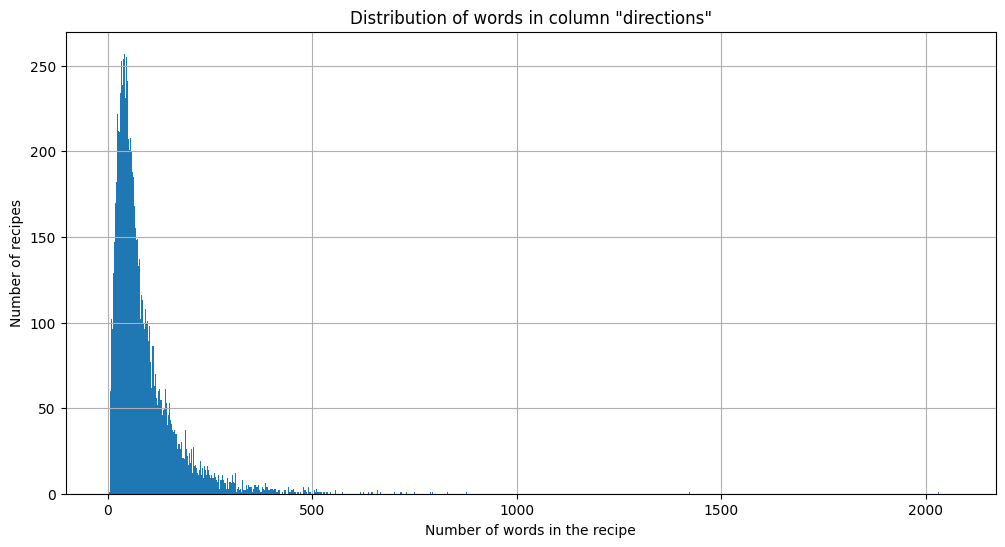

In [40]:
# Visualize the distribution of the number of words in column "directions" to show how long recipes are (in number of words)
plt.figure(figsize=(12,6))
plt.hist(df['dir_word_count'], bins=max_words, range=(0, max_words))
plt.title('Distribution of words in column \"directions\"')
plt.xlabel('Number of words in the recipe')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [17]:
# Analyzing recipe word count distribution
word_counts = df['dir_word_count'].dropna()
mean_word_count = word_counts.mean()
median_word_count = word_counts.median()
percentile_90 = word_counts.quantile(0.9)
percentile_95 = word_counts.quantile(0.95)

print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean word count: 428.44995742010667
Median word count: 312.0
90th percentile: 873.0
95th percentile: 1147.0


In [41]:
# Count recipes with less than upper_threshold words
upper_threshold = 300
count_less_threshold = (word_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} words.")

48.02% of the recipes have at most 300 words.


In [42]:
# Count recipes with more than lower_threshold words
lower_threshold = 20
count_more_threshold = (word_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} words.")

99.99% of the recipes have at least 20 words.


### Analyze entities distribution
The aim of this section is to analyse the number of elements in the NER column, which contains the number of entities in each recipe, and to provide a distribution, giving a rough measure of the "complexity" of the recipe.

In [43]:
# Define a new column containing the number of entities of each recipe
ner_column = 'ner_len'

df[ner_column] = df['NER'].apply(lambda x: len(ast.literal_eval(x)))
print(df[ner_column])

2015528    10
1608734    17
778500      4
1334975     8
116562      2
           ..
1664318     3
195905      8
2014553     9
71391       7
975226     10
Name: ner_len, Length: 22307, dtype: int64


In [44]:
# Retreive the lenght and index of recipe with highest and lowest NER number
max_ner_len = df[ner_column].max()
min_ner_len = df[ner_column].min()

max_ner_len_idx = df[ner_column].idxmax()
print(f"Recipes have between {min_ner_len} and {max_ner_len} entities.")

print(f"The longest recipe has {max_ner_len} words and it is at location {max_ner_len_idx}.")
#print(df['NER'].loc[max_ner_len_idx])

Recipes have between 1 and 71 entities.
The longest recipe has 71 words and it is at location 808450.


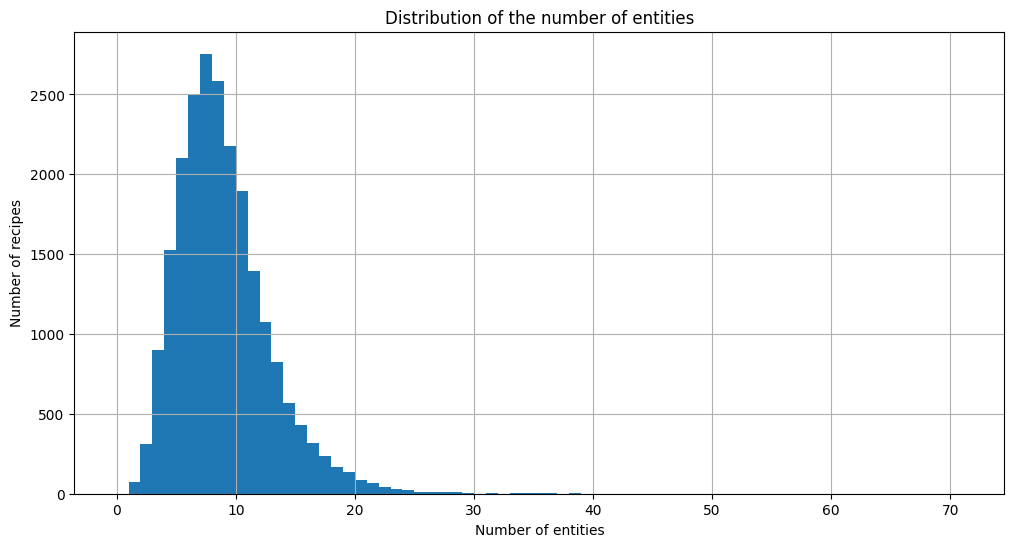

In [45]:
# Visualize the number of entities in each recipe
plt.figure(figsize=(12,6))
plt.hist(df[ner_column], bins=max_ner_len, range=(0, max_ner_len))
plt.title('Distribution of the number of entities')
plt.xlabel('Number of entities')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [46]:
# Analyzing recipe NER count distribution
entities_counts = df[ner_column].dropna()
mean_entities_count = entities_counts.mean()
median_entities_count = entities_counts.median()
percentile_90 = entities_counts.quantile(0.9)
percentile_95 = entities_counts.quantile(0.95)

print(f"Mean NER count: {mean_entities_count}")
print(f"Median NER count: {median_entities_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean NER count: 8.483480521809298
Median NER count: 8.0
90th percentile: 13.0
95th percentile: 16.0


In [47]:
# Count recipes with less than upper_threshold entities
upper_threshold = 25
count_less_threshold = (entities_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} entities.")

99.72% of the recipes have at most 25 entities.


In [48]:
# Count recipes with more than lower_threshold entities
lower_threshold = 3
count_more_threshold = (entities_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} entities.")

98.28% of the recipes have at least 3 entities.


In [54]:
# Filter recipes where there are NO NER
zero_NER_recipes = df[df['ner_len'] == 0]

print(zero_NER_recipes[['title', 'NER']])
# Drop recipes where there are no NERs
df = df[df['ner_len'] != 0]

Empty DataFrame
Columns: [title, NER]
Index: []


It means that the NER process didn't detect any entities for these recipes. This could happen for various reasons, such as:
- The recipe doesn't contain recognizable entities like ingredients, amounts, or special terms.
- The NER process might not be comprehensive enough to detect all relevant entities in the recipe.
- The recipe could be incomplete or malformed in a way that prevents proper entity recognition.

NB: It may happens that there are NO entries without NER, since we are using a subsample of the original dataset. 